In [1]:
import numpy as np
import networkx as nx
import glob
import matplotlib.pyplot as plt

from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection
import itertools
from scipy.optimize import minimize

from cutqc.main import CutQC
from qiskit import *
from qiskit.circuit import Qubit
from qiskit.circuit.library.standard_gates import XGate
from qiskit.circuit import ControlledGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler import PassManager

import qsplit_circuit_cutter as qcc
import qsplit_mlrecon_methods as qmm

import dqva

from utils.graph_funcs import *
from utils.helper_funcs import *

# Generate cut-DQVA with updated QSPLIT

In [2]:
def fidelity(dist, actual_dist):
    nq = len(list(actual_dist.keys())[0])
    all_bits = [ "".join(bits) for bits in itertools.product(["0", "1"], repeat = nq) ]
    fidelity = sum( np.sqrt(actual_dist[bits] * dist[bits], dtype = complex)
                    for bits in all_bits
                    if actual_dist.get(bits) and dist.get(bits) )**2
    return fidelity.real if fidelity.imag == 0 else fidelity

## Functions for circuit generation
Once these functions are totally debugged and working, they should be added to `ansatz/dqv_cut_ansatz.py`

In [24]:
def apply_mixer(circ, alpha, init_state, G, cut_nodes, cutedges, subgraph_dict,
                barriers, decompose_toffoli, mixer_order, hot_nodes,
                verbose=0):
    # Pad the given alpha parameters to account for the zeroed angles
    pad_alpha = [None]*len(init_state)
    next_alpha = 0
    for qubit in mixer_order:
        bit = list(reversed(init_state))[qubit]
        if bit == '1' or next_alpha >= len(alpha) \
           or (qubit in cut_nodes and qubit not in hot_nodes):
            continue
        else:
            pad_alpha[qubit] = alpha[next_alpha]
            next_alpha += 1
    if verbose > 0:
        print('Mixer order:', mixer_order)
        print('init_state: {}, alpha: {}, pad_alpha: {}'.format(init_state,
                                                                alpha, pad_alpha))
        print('Subgraph dict:', subgraph_dict)

    # apply partial mixers V_i(alpha_i)
    if mixer_order is None:
        mixer_order = list(G.nodes)
    for qubit in mixer_order:
        if pad_alpha[qubit] == None or not G.has_node(qubit):
            # Turn off mixers for qubits which are already 1
            continue

        neighbors = list(G.neighbors(qubit))
        anc_idx = subgraph_dict[qubit]

        if verbose > 0:
            print('qubit:', qubit, 'num_qubits =', len(circ.qubits), 'neighbors:', neighbors)

        # construct a multi-controlled Toffoli gate, with open-controls on q's neighbors
        # Qiskit has bugs when attempting to simulate custom controlled gates.
        # Instead, wrap a regular toffoli with X-gates
        ctrl_qubits = [circ.qubits[i] for i in neighbors] 
        if decompose_toffoli > 0:
            # apply the multi-controlled Toffoli, targetting the ancilla qubit
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[anc_idx])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
        else:
            mc_toffoli = ControlledGate('mc_toffoli', len(neighbors)+1, [], num_ctrl_qubits=len(neighbors),
                                        ctrl_state='0'*len(neighbors), base_gate=XGate())
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[anc_idx]])

        # apply an X rotation controlled by the state of the ancilla qubit
        circ.crx(2*pad_alpha[qubit], circ.ancillas[anc_idx], circ.qubits[qubit])

        # apply the same multi-controlled Toffoli to uncompute the ancilla
        if decompose_toffoli > 0:
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
            circ.mcx(ctrl_qubits, circ.ancillas[anc_idx])
            for ctrl in ctrl_qubits:
                circ.x(ctrl)
        else:
            circ.append(mc_toffoli, ctrl_qubits + [circ.ancillas[anc_idx]])

        if barriers > 1:
            circ.barrier()

def apply_phase_separator(circ, gamma, G):
    for qb in G.nodes:
        circ.rz(2*gamma, qb)

In [25]:
def gen_cut_dqva(G, partition, uncut_nodes, P=1, params=[], init_state=None,
                 barriers=1, decompose_toffoli=1, mixer_order=None,
                 hot_nodes=[], verbose=0):

    nq = len(G.nodes)
    subgraphs, cutedges = get_subgraphs(G, partition)

    if verbose > 0:
        print('Current partition:', partition)
        print('subgraphs:', [list(g.nodes) for g in subgraphs])
        print('cutedges:', cutedges)
        # The hot nodes parameter controls which of the nodes on the cut edges we will
        # hit with a mixer unitary. The other nodes on the cut are "cold" and their
        # mixer will be Identity
        print('hot nodes:', hot_nodes)

    # Step 1: Jump Start
    # Run an efficient classical approximation algorithm to warm-start the optimization
    # (For now, we will select the trivial set of bitstrings with Hamming weight equal to 1)
    # Each partition should get its own jump start
    if init_state is None:
        init_state = '0'*nq

    # Step 2: Mixer Initialization
    dqv_circ = QuantumCircuit(nq, name='q')

    # Add an ancilla qubit, 1 for each subgraph, for implementing the mixer unitaries
    anc_reg = AncillaRegister(len(subgraphs), 'anc')
    dqv_circ.add_register(anc_reg)

    #print('Init state:', init_state)
    for qb, bit in enumerate(reversed(init_state)):
        if bit == '1':
            dqv_circ.x(qb)
    if barriers > 0:
        dqv_circ.barrier()

    # parse the variational parameters
    cut_nodes = [n for n in G.nodes if n not in uncut_nodes]
    uncut_nonzero = len([n for n in uncut_nodes if init_state[n] != '1'])
    num_params = P * (uncut_nonzero + 1) + len(hot_nodes)
    assert (len(params) == num_params),"Incorrect number of parameters!"
    alpha_list = []
    gamma_list = []
    for p in range(P):
        chunk = uncut_nonzero + 1
        if p == 0:
            chunk += len(hot_nodes)
        cur_selection = params[p*chunk:(p+1)*chunk]
        alpha_list.append(cur_selection[:-1])
        gamma_list.append(cur_selection[-1])
        
    if verbose > 0:
        for i in range(P):
            print('alpha_{}: {}'.format(i, alpha_list[i]))
            print('gamma_{}: {}'.format(i, gamma_list[i]))
            
    subgraph_dict = {}
    for i, subgraph in enumerate(subgraphs):
        for qubit in subgraph:
            subgraph_dict[qubit] = i

    for i, (alphas, gamma) in enumerate(zip(alpha_list, gamma_list)):
        apply_mixer(dqv_circ, alphas, init_state, G, cut_nodes, cutedges,
                    subgraph_dict, barriers, decompose_toffoli, mixer_order,
                    hot_nodes, verbose=verbose)
        
        if barriers == 1:
            dqv_circ.barrier()

        apply_phase_separator(dqv_circ, gamma, G)
        
        if barriers == 0:
            dqv_circ.barrier()
            
        # in every layer of the ansatz after the first,
        # all hot nodes should be turned cold
        if i == 0:
            hot_nodes = []

    if decompose_toffoli > 1:
        basis_gates = ['x', 'h', 'cx', 'crx', 'rz', 't', 'tdg', 'u1']
        pass_ = Unroller(basis_gates)
        pm = PassManager(pass_)
        dqv_circ = pm.run(dqv_circ)

    return dqv_circ

## Grab a test graph to test DQVA+circuit cutting

50
True


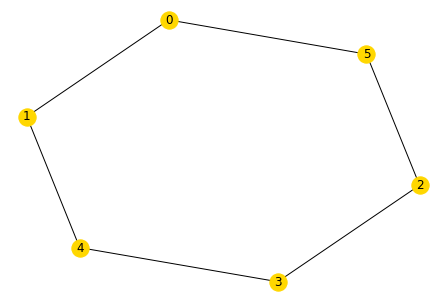

In [33]:
test_graphs = glob.glob('benchmark_graphs/N6_d2_graphs/*')
print(len(test_graphs))
test_graph = test_graphs[1]
G = graph_from_file(test_graph)
print(nx.is_connected(G))
nx.draw_spring(G, with_labels=True, node_color='gold')

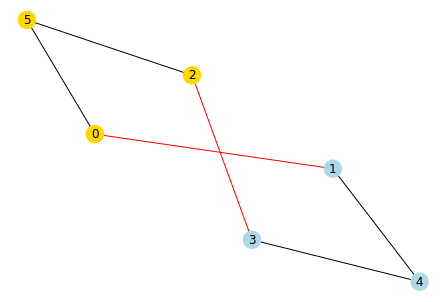

In [34]:
kl_bisection = kernighan_lin_bisection(G)
view_partition(kl_bisection, G)

## Circuit initialization
The following code block initializes the parameters needed by the `gen_cut_dqva()` function

In [35]:
nq = len(G.nodes())
P = 1
mixer_order = list(range(nq))
np.random.shuffle(mixer_order)

# Set the initial state
init_state = '0'*nq

# This code follows the text in the Overleaf draft
(G_A, G_B), cutedges = get_subgraphs(G, kl_bisection)
print('G_A nodes:', G_A.nodes)
print('G_B nodes:', G_B.nodes)
print('cutedges:', cutedges)
cut_nodes = []
for edge in cutedges:
    cut_nodes.extend(edge)
cutnodes = list(set(cut_nodes))
print('cutnodes:', cut_nodes)
uncut_nodes = list(set(G.nodes).difference(set(cut_nodes)))
print('uncut nodes:', uncut_nodes)

Q_A_uc = [node for node in G_A.nodes if node in uncut_nodes]
Q_A_c = [node for node in G_A.nodes if node in cut_nodes]

Q_B_uc = [node for node in G_B.nodes if node in uncut_nodes]
Q_B_c = [node for node in G_B.nodes if node in cut_nodes]

print('Q_A_uc: {}, Q_A_c: {}'.format(Q_A_uc, Q_A_c))
print('Q_B_uc: {}, Q_B_c: {}'.format(Q_B_uc, Q_B_c))

# Initialization
cut_limit = 1 # Set upper limit on the number of allowed cuts
starter_idx = 1 # Which subgraph should we start with? Options: 0, 1

starter_graph = (G_A, G_B)[starter_idx]
starter_cut_nodes = (Q_A_c, Q_B_c)[starter_idx]
np.random.shuffle(starter_cut_nodes)
starter_cut_nodes = sorted(starter_cut_nodes,
                           key=lambda n: len((list(starter_graph.neighbors(n)))),
                           reverse=True)
print(starter_cut_nodes)

hot_nodes = []
cut_count = 0
for node in starter_cut_nodes:
    t = len([e for e in cutedges if node in e])
    print('node, t:', node, t)
    if t + cut_count <= cut_limit and list(reversed(init_state))[node] != '1':
        hot_nodes.append(node)
        cut_count += t
print('hot_nodes:', hot_nodes)

uncut_nonzero = len([n for n in uncut_nodes if init_state[n] != '1'])
num_params = P * (uncut_nonzero + 1) + len(hot_nodes)

params = list(range(1, num_params + 1))
print('params:', params)

G_A nodes: [0, 2, 5]
G_B nodes: [1, 3, 4]
cutedges: [(0, 1), (3, 2)]
cutnodes: [0, 1, 3, 2]
uncut nodes: [4, 5]
Q_A_uc: [5], Q_A_c: [0, 2]
Q_B_uc: [4], Q_B_c: [1, 3]
[3, 1]
node, t: 3 1
node, t: 1 1
hot_nodes: [3]
params: [1, 2, 3, 4]


In [36]:
# Generate the full dqva ansatz
mixer_order = list(range(nq))
circ = gen_cut_dqva(G, kl_bisection, uncut_nodes, P=P, params=params,
                    init_state=init_state, barriers=2, decompose_toffoli=1,
                    mixer_order=mixer_order, hot_nodes=hot_nodes, verbose=1)
circ.draw(fold=-1)

Current partition: ({0, 2, 5}, {1, 3, 4})
subgraphs: [[0, 2, 5], [1, 3, 4]]
cutedges: [(0, 1), (3, 2)]
hot nodes: [3]
alpha_0: [1, 2, 3]
gamma_0: 4
Mixer order: [0, 1, 2, 3, 4, 5]
init_state: 000000, alpha: [1, 2, 3], pad_alpha: [None, None, None, 1, 2, 3]
Subgraph dict: {0: 0, 2: 0, 5: 0, 1: 1, 3: 1, 4: 1}
qubit: 3 num_qubits = 8 neighbors: [4, 2]
qubit: 4 num_qubits = 8 neighbors: [1, 3]
qubit: 5 num_qubits = 8 neighbors: [0, 2]


░                                         ░                                    ░ ┌───┐       ┌───┐  ┌───┐     ┌───┐ ░ ┌───────┐
  q_0: ─░─────────────────────────────────────────░────────────────────────────────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░─┤ RZ(8) ├
        ░                                         ░ ┌───┐       ┌───┐  ┌───┐     ┌───┐ ░ └───┘  │    └───┘  └───┘  │  └───┘ ░ ├───────┤
  q_1: ─░─────────────────────────────────────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░────────┼──────────────────┼────────░─┤ RZ(8) ├
        ░ ┌───┐     ┌───┐  ┌───┐            ┌───┐ ░ └───┘  │    └───┘  └───┘  │  └───┘ ░ ┌───┐  │    ┌───┐  ┌───┐  │  ┌───┐ ░ ├───────┤
  q_2: ─░─┤ X ├──■──┤ X ├──┤ X ├─────────■──┤ X ├─░────────┼──────────────────┼────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░─┤ RZ(8) ├
        ░ └───┘  │  └───┘┌─┴───┴─┐       │  └───┘ ░ ┌───┐  │    ┌───┐  ┌───┐  │  ┌───┐ ░ └───┘  │    └───┘  └───┘  │  └───┘ ░ ├───────┤
  q_3: ─░────────┼───────┤ RX(2) ├───────┼────────░─┤ X ├──■────┤ X ├──┤ X ├──■──┤ X ├─░────────┼──────────────────┼────────░─┤ RZ(8) ├
        ░ ┌───┐  │  ┌───┐└───┬───┘┌───┐  │  ┌───┐ ░ └───┘  │  ┌─┴───┴─┐└───┘  │  └───┘ ░        │                  │        ░ ├───────┤
  q_4: ─░─┤ X ├──■──┤ X ├────┼────┤ X ├──■──┤ X ├─░────────┼──┤ RX(4) ├───────┼────────░────────┼──────────────────┼────────░─┤ RZ(8) ├
        ░ └───┘  │  └───┘    │    └───┘  │  └───┘ ░        │  └───┬───┘       │        ░        │  ┌───────┐       │        ░ ├───────┤
  q_5: ─░────────┼───────────┼───────────┼────────░────────┼──────┼───────────┼────────░────────┼──┤ RX(6) ├───────┼────────░─┤ RZ(8) ├
        ░        │           │           │        ░        │      │           │        ░      ┌─┴─┐└───┬───┘     ┌─┴─┐      ░ └───────┘
anc_0: ─░────────┼───────────┼───────────┼────────░────────┼──────┼───────────┼────────░──────┤ X ├────■─────────┤ X ├──────░──────────
        ░      ┌─┴─┐         │         ┌─┴─┐      ░      ┌─┴─┐    │         ┌─┴─┐      ░      └───┘              └───┘      ░          
anc_1: ─░──────┤ X ├─────────■─────────┤ X ├──────░──────┤ X ├────■─────────┤ X ├──────░────────────────────────────────────░──────────
        ░      └───┘                   └───┘      ░      └───┘              └───┘      ░                                    ░

## Locate the cut locations
Using all the information above, programmatically locate where the cuts should be placed to partition
the DQVA circuit into two subcircuits

In [37]:
# Programmatically locate the cut locations
#cuts = [(circ.qubits[2], 6)]
print('hot nodes:', hot_nodes)
applied_mixers = [n for n in uncut_nodes + hot_nodes if list(reversed(init_state))[n] != '1']
print('applied mixers:', applied_mixers)

cuts = []
for edge in cutedges:
    print('cut edge:', edge)
    if edge[0] in hot_nodes:
        cut_qubit = edge[1]
        loc_qubit = edge[0]
    elif edge[1] in hot_nodes:
        cut_qubit = edge[0]
        loc_qubit = edge[1]
    else:
        continue
    assert cut_qubit not in hot_nodes
    print('cut_qubit:', cut_qubit, ', loc_qubit:', loc_qubit)
    
    num_mixers_before = 0
    num_mixers_after  = 0
    passed = False # a boolean to keep track when we've passed the loc_qubit
    for mixer in mixer_order:
        # step through each partial mixer in order
        if mixer not in applied_mixers:
            # if this partial mixer is identity, skip
            continue
        
        if mixer == loc_qubit:
            # this is the partial mixer where we'll apply the cut(s)
            passed = True
        
        else:
            # check if this mixer has a control on the cut qubit
            if cut_qubit in list(G.neighbors(mixer)):
                if passed:
                    # if we've passed the loc_qubit
                    num_mixers_after += 1
                else:
                    # if we haven't passed the loc_qubit
                    num_mixers_before += 1
    
    print('num_mixers_before:', num_mixers_before)
    print('num_mixers_after:', num_mixers_after)
    
    if num_mixers_before > 0:
        cuts.append((circ.qubits[cut_qubit], num_mixers_before * 6))
    if num_mixers_after > 0:
        cuts.append((circ.qubits[cut_qubit], num_mixers_after * 6))
    
print('cuts:')
#cuts = [(Qubit(QuantumRegister(12, 'q'), 9), 6), (Qubit(QuantumRegister(12, 'q'), 1), 12)]
#cuts = cuts[:-1]
print(cuts)

hot nodes: [3]
applied mixers: [4, 5, 3]
cut edge: (0, 1)
cut edge: (3, 2)
cut_qubit: 2 , loc_qubit: 3
num_mixers_before: 0
num_mixers_after: 1
cuts:
[(Qubit(QuantumRegister(6, 'q'), 2), 6)]


## With the given cut locations, split and simulate the circuit

In [38]:
frag_num = 2
fragments, wire_path_map = qcc.cut_circuit(circ, cuts)
for i, frag in enumerate(fragments):
    print('Fragment', i)
    print(frag.draw(fold=120))

print()
for key, val in wire_path_map.items():
    print(key, '-->', val)

Fragment 0
     ┌───┐     ┌───┐  ┌───┐                ┌───┐┌───────┐
q_0: ┤ X ├──■──┤ X ├──┤ X ├─────────────■──┤ X ├┤ RZ(8) ├
     └───┘┌─┴─┐└───┘  └───┘           ┌─┴─┐└───┘└───────┘
q_1: ─────┤ X ├─────────■─────────────┤ X ├──────────────
     ┌───┐└─┬─┘┌───┐    │      ┌───┐  └─┬─┘┌───┐┌───────┐
q_2: ┤ X ├──■──┤ X ├────┼──────┤ X ├────■──┤ X ├┤ RZ(8) ├
     └───┘     └───┘┌───┴───┐┌─┴───┴─┐     └───┘└───────┘
q_3: ───────────────┤ RX(6) ├┤ RZ(8) ├───────────────────
                    └───────┘└───────┘                   
Fragment 1
     ┌───┐     ┌───┐  ┌───┐            ┌───┐     ┌───────┐┌───────┐                   
q_0: ┤ X ├──■──┤ X ├──┤ X ├─────────■──┤ X ├─────┤ RX(4) ├┤ RZ(8) ├───────────────────
     ├───┤  │  └───┘  └───┘         │  └───┘┌───┐└───┬───┘└─┬───┬─┘     ┌───┐┌───────┐
q_1: ┤ X ├──┼───────────────────────┼────■──┤ X ├────┼──────┤ X ├────■──┤ X ├┤ RZ(8) ├
     └───┘  │       ┌───────┐┌───┐  │    │  ├───┤    │      ├───┤    │  ├───┤├───────┤
q_2: ───────┼───────┤

In [39]:
frag_data = qmm.collect_fragment_data(fragments, wire_path_map, shots=500000, tomography_backend='qasm_simulator')
direct_models = qmm.direct_fragment_model(frag_data)
likely_models = qmm.maximum_likelihood_model(direct_models)

likely_recombined_dist = qmm.recombine_fragment_models(likely_models, wire_path_map)
print({key: val for key, val in likely_recombined_dist.items() if val > 0.001})

{'00000000': 0.04956051929322031, '00010000': 0.2366769277906791, '00001000': 0.6933055106276432, '00100000': 0.001031198944446434, '00110000': 0.004924426925770206, '00101000': 0.014425544830561556}


In [40]:
circ.measure_all()
shots = 200000
result = execute(circ, backend=Aer.get_backend('qasm_simulator'), shots=shots).result()
counts = result.get_counts(circ)
actual_dist = {sample: counts[sample] / shots for sample in counts.keys()}
print(actual_dist)

{'00000000': 0.050125, '00010000': 0.23476, '00100000': 0.00098, '00101000': 0.01431, '00110000': 0.004705, '00001000': 0.69512}


In [41]:
fidelity(likely_recombined_dist, actual_dist)

0.9999140646441325